<a href="https://colab.research.google.com/github/kjh8331267/News_NLP_Test/blob/main/hdbscan_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kpf-sbert로 clustering

In [3]:
!pip install sentence_transformers

In [2]:
import pandas as pd
import numpy as np
import re
import itertools
from datetime import datetime

import matplotlib.pyplot as plt

In [3]:
from sentence_transformers import SentenceTransformer
model_name = 'bongsoo/kpf-sbert-128d-v1'
model = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when p

In [4]:
def text_cleaning(doc):
    '''
    function name : 기사원문 전처리 함수

    brief : 토큰나이징 전에 영문, 특수문자, 숫자 제거 및 기타 단어 변환
    date : 23.01.25
    param : doc(str) - 기사원문 1개
    return : 전처리한 기사원문
    '''
    # 중요 영어단어를 한글로 변경
    doc = re.sub("SVB", "실리콘밸리은행", doc)

    # 한국어와 문장을 구분하는 '.'를 제외한 글자를 제거
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 .]", "", doc)

    # 특수문자를 제거하는 패턴.
    #doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)

    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")

    # 기타 문자 변환
    doc = re.sub("서울경제|매일경제|한국경제|주간\s*경제지표|특징주|블룸버그\s*통신|로이터\s*통신", "", doc)
    doc = re.sub("이 기사는 국내 최대 해외 투자정보 플랫폼 한경 글로벌마켓에 게재된 기사입니다.", "", doc)
    doc = re.sub("이 기사는 프리미엄 스타트업 미디어 플랫폼 한경 긱스에 게재된 기사입니다.", "", doc)
    doc = re.sub("한국경제신문의 프리미엄 스타트업 미디어 플랫폼 긱스(Geeks)가", "", doc)
    doc = re.sub("이 기사는 국내 최대 해외 투자정보 플랫폼 한경 글로벌마켓에 게재된 기사입니다.", "", doc)
    doc = re.sub("스타트업 뉴스를 브리핑합니다.", "", doc)
    doc = re.sub("프리미엄 스타트업 미디어 플랫폼", "", doc)
    doc = re.sub("매경 라이징 임팩트", "", doc)
    doc = re.sub("...기자|... 기자|... ?기자", "", doc)
    doc = re.sub("마켓워치", "", doc)
    doc = re.sub("현지시간", "", doc)
    doc = re.sub("글로벌 리서치", "", doc)
    doc = re.sub("게티 이미지 뱅크|게티이미지 뱅크|게티 이미지뱅크|게티이미지뱅크", "", doc)
    doc = re.sub("이메일|카카오톡|제보|제보하기|전화|검색|채널 추가|유튜브 구독|네이버 유튜브|전화 추가|뉴스를 구독해주세요", "", doc)
    doc = re.sub("영상 편집|영상편집|영상 취재|영상취재|여러분의 제보를 기다립니다|제보", "", doc)
    doc = re.sub("이벤트 금지", "", doc)
    doc = re.sub("뉴스\s*스탠드|재배포\s*금지|무단\s*전재|소통\s*커뮤니티|경향\s*신문|영상\s*취재|영상\s*편집|카카오톡|전화|이메일|앵커|뉴스데스크|뉴스|제보", "", doc)
    return doc

In [5]:
data_path = '/content/drive/MyDrive/issue_trends/news_202208.csv'
df_raw_data = pd.read_csv(data_path)

# 기사내용 nan인 행 제거
df_raw_data = df_raw_data.dropna(subset = ['content']).reset_index()
df_raw_data = df_raw_data.drop_duplicates(subset = ["title"]) # 겹치는 뉴스 제거
df_raw_data = df_raw_data.drop_duplicates(subset = ["content"]) # 겹치는 뉴스 제거

drop_text = ['[표]', '[데이터로 보는 증시]']
for i in drop_text:
    doc_boolean_tmp = list(map(lambda x: i not in x, df_raw_data.title))
    df_raw_data = df_raw_data.loc[doc_boolean_tmp, :]

In [38]:
# 기사 본문을 문장으로 실시
#
df_data = df_raw_data.content
lst_sent_all = [text_cleaning(doc).split(". ") for doc in df_data]
lst_sent_all = list(itertools.chain(*lst_sent_all))

import random
lst_sent = random.sample(lst_sent_all, 500)
print(len(lst_sent))

500


In [25]:
# 제목으로 실시
df_data = df_raw_data.title
lst_sent_all = [text_cleaning(doc) for doc in df_data]

import random
lst_sent = random.sample(lst_sent_all, 500)
print(len(lst_sent))

500


In [39]:
corpus_embeddings = model.encode(lst_sent)
print(corpus_embeddings)

[[-0.29207894  0.12409651 -0.02028739 ...  0.01800864 -0.26117724
  -0.09526815]
 [-0.29909465 -0.21193384  0.20409296 ... -0.18339042 -0.03536291
  -0.07129458]
 [ 0.37774938  0.04773148 -0.41356507 ... -0.09776408 -0.4135768
  -0.06538522]
 ...
 [ 0.05223875  0.03531515 -0.05703586 ... -0.09730384  0.0183092
  -0.00631632]
 [ 0.13575175 -0.03343292 -0.272408   ... -0.18058363  0.009017
   0.22116908]
 [-0.18794745  0.36707455 -0.01850267 ...  0.26026732 -0.04859322
   0.1617425 ]]


In [1]:
!pip install umap-learn

In [42]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=3,
                            metric='cosine').fit_transform(corpus_embeddings)

In [43]:
import hdbscan

cluster = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(umap_embeddings) #corpus_embeddings

docs_df = pd.DataFrame(lst_sent, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_df.Topic.value_counts()

Topic
-1     264
 24     20
 13     15
 22     15
 7      14
 11     14
 9      14
 8      12
 10     11
 19     11
 3      10
 6       9
 14      8
 0       8
 23      8
 4       7
 15      7
 17      7
 5       7
 2       6
 1       6
 20      6
 18      6
 21      5
 12      5
 16      5
Name: count, dtype: int64

In [33]:
docs_per_topic.Doc[0]

'월 휘발유 소비량 작년보다  늘어항공유도  증가 동십자각 기회는 자주 오지 않는다 나홀로 상승 서초도 멈춰수도권 규제지역 곳도 안올라 심은지의 경매인사이트강남도 어쩔 수 없네경매시장서 유찰 잇따라  고양삼송 신원마을단지 소외층 어르신 돌봄 노노케어 활동 펼쳐 쏘카 상장 이틀째 반등 시동장중 공모가 상회하기도 사진홈앤쇼핑하이트진로 중기 아이디어 상품 발굴위해 맞손 한화에어로  에어택시 부품 공급 예탁원 경영위원회 신설경영 본격 추진 년새 억 뛰었다고금리에도 한남더힐 자이언트 스텝 왜 한경라씨로 서울시 년간 조 투입 양육지원 정책 발표...수혜주는 금융티타임 오화경 회장의 꼰대가 되지 않는 법 컬리 상장 예비심사 다음 주 결론상장 시기 검토 기준금리 년 새  껑충이자 눈덩이에 영끌족 비상 조미현의 외환금융 워치 한중수교 년 비즈니스 포럼자유무역 질서 회복 노력해야 일하는 사람 수에 맞춰 건설현장 편의시설 확충 나선다 글로벌 프리미엄 건강가전기업 오씸 전속모델로 배우 손석구 발탁 한미 주년무협 골드버그 대사 초청 간담회  시총 조원 넘어년 월 이후 년여만 임대아파트서도 골프를공공지원 민간임대 어디까지 왔나 스타워즈 개막 첫날 코스피 하락에 휘청박철희 선두로 출발 베이비 스텝에 시장 안도...국내 증시 소폭 상승 삼성 등 개 대기업 말레이시아에 탄소 저장 허브 함께 만든다 영업이익률  하이텍실적 정점 논란   엔데버티빙  달성 더 기다려야목표가 하나 한국투자증권 채권 라인업 강화개인투자자 투자 기회 확대 경영난에 매각중인데대표 생일 맞아 선상 파티 벌인 이 회사 랩스 베스틴 굿디자인 어워드서 년 연속 우수디자인 선정 금융 자격증이 필수조건 아니야은행 인사 담당자가 말하는 인재상은 제일건설 남중동 오투그란데 뉴 퍼스트 금일 청약홈에서 순위 청약 받아 한화 방산의 대표주자 한화에어로스페이스 신고가보름 만에  엔터 블랙핑크 효과에 주가 쑥 넘게 올라 년 장기투자 도 위험상품가입자 선택지 좁히는 기준 바꿔야 유안타증권 미국  공모주 청약 대행 서비스 오픈 위기에 강한 기업

<Axes: >

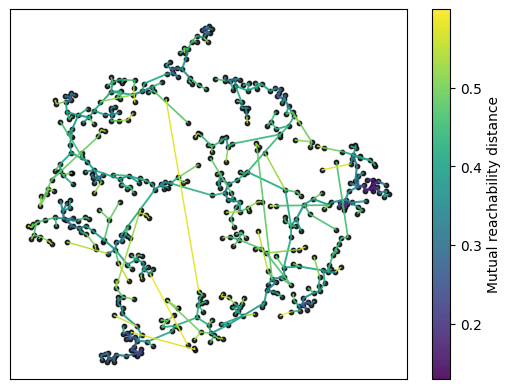

In [44]:
# 훈련된 모델을 사용하여 minimum_spanning_tree 생성
cluster.minimum_spanning_tree_.plot(edge_alpha=0.9, edge_cmap='viridis', node_size=10, edge_linewidth=1)

<Axes: ylabel='$\\lambda$ value'>

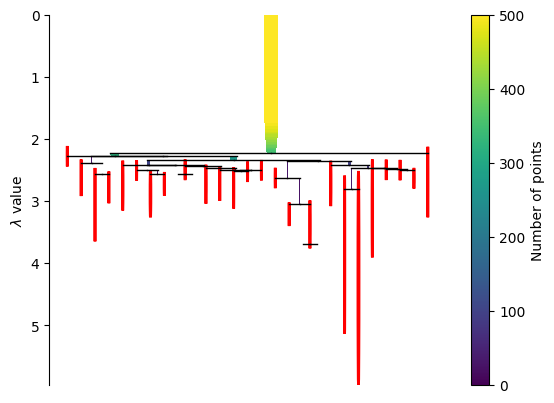

In [45]:
# 훈련된 모델을 사용하여 condensed_tree 생성
# cluster도 함께 보기위해 select_clusters=True 설정
cluster.condensed_tree_.plot(select_clusters=True)

In [31]:
# 클러스터별 주제어 추출확인
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [46]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(lst_sent))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,264
25,24,20
14,13,15
23,22,15
10,9,14
12,11,14
8,7,14
9,8,12
20,19,11
11,10,11


In [47]:
pd.DataFrame(top_n_words)

,-1,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,"(있다, 0.017334619737092046)","(대학, 0.10721283335654845)","(디지털, 0.12758217199598473)","(부회장은, 0.1401642687603858)","(순환, 0.14971515464503257)","(남구, 0.10224927625670825)","(피해를, 0.14341525952383072)","(환율은, 0.1894813262871882)","(영업이익은, 0.11316360321802267)","(저피탐, 0.06495836373955584)",...,"(신한, 0.4247277629124805)","(근로자를, 0.17528447358292842)","(관련, 0.12433100823398674)","(지난해, 0.11339197117183032)","(만명, 0.13795182106578002)","(얼음정수기를, 0.13466977848444503)","(금액도, 0.14452576973074863)","(제공, 0.059201610295780804)","(출발했다, 0.13810240218715983)","(인터넷, 0.12991672747911168)"
1,"(분기, 0.015470558885519613)","(근무할, 0.10721283335654845)","(주시기, 0.10618194072812012)","(단지에, 0.08513161778660536)","(제네시스랩, 0.08560404523817436)","(월산동, 0.10224927625670825)","(한편, 0.1013068477179026)","(천연가스선물, 0.1894813262871882)","(감소했으나, 0.0862728268415976)","(제공되는, 0.06495836373955584)",...,"(신한금융은, 0.23902338840085352)","(경북, 0.16241256538901844)","(민간, 0.09375366480198641)","(등을, 0.09801144215553553)","(만명이, 0.0788780131123178)","(한정, 0.13466977848444503)","(아니냐는, 0.14452576973074863)","(유통, 0.058428157860976146)","(만들어졌다, 0.13810240218715983)","(뱅킹이, 0.07311303645202578)"
2,"(있는, 0.01290901665206014)","(이수한, 0.10721283335654845)","(공급망, 0.10618194072812012)","(벽을, 0.08513161778660536)","(그룹의, 0.08560404523817436)","(출범, 0.0947406631435941)","(최근, 0.06815879952836457)","(거래를, 0.1894813262871882)","(억원으로, 0.07544240214534845)","(나설, 0.06018818599710684)",...,"(같았다, 0.23902338840085352)","(소개하기도, 0.09864457299082843)","(다양한, 0.07411092865288972)","(때도, 0.09006678403510422)","(보면, 0.0788780131123178)","(전용, 0.11232122404849003)","(규모다, 0.14452576973074863)","(한우, 0.058428157860976146)","(월마트는, 0.13810240218715983)","(너구리, 0.07311303645202578)"
3,"(통해, 0.01164295534392366)","(상시, 0.10721283335654845)","(더불어, 0.09285218725581348)","(여름휴가를, 0.08513161778660536)","(분석, 0.07931776449231134)","(이달, 0.07904996202531255)","(사전에, 0.06153077325170487)","(원에, 0.13633236834227766)","(에서, 0.06669840545885747)","(친환경, 0.06018818599710684)",...,"(도심권만, 0.23902338840085352)","(호주를, 0.09864457299082843)","(노사는, 0.060336000955555254)","(투자자로, 0.09006678403510422)","(통신, 0.0788780131123178)","(카페, 0.07578790363929502)","(맞는, 0.14452576973074863)","(주식을, 0.058428157860976146)","(하위, 0.13810240218715983)","(주파할, 0.07311303645202578)"
4,"(위해, 0.01160291916413971)","(쿨비즈데이를, 0.10721283335654845)","(협력, 0.09285218725581348)","(직원들의, 0.08513161778660536)","(경제, 0.07139798737966033)","(글로벌, 0.07439599113122171)","(앓고, 0.06153077325170487)","(거래일, 0.13633236834227766)","(포인트, 0.06669840545885747)","(개발, 0.06018818599710684)",...,"(패밀리오피스는, 0.23902338840085352)","(장보고, 0.09864457299082843)","(극대화하는, 0.060336000955555254)","(신임, 0.09006678403510422)","(출원, 0.0788780131123178)","(기업가치, 0.07578790363929502)","(수치다, 0.14452576973074863)","(에너지, 0.058428157860976146)","(그렇게, 0.13810240218715983)","(주치의, 0.07311303645202578)"
5,"(올해, 0.010902497888530108)","(있도록, 0.07596161175588632)","(등의, 0.07725737540549947)","(소개하며, 0.08513161778660536)","(오는, 0.06618136355607562)","(따르면, 0.06906854534507761)","(하냐에, 0.06153077325170487)","(종가보다, 0.13633236834227766)","(상반기, 0.06669840545885747)","(설계, 0.056803691027085886)",...,"(패밀리오피스, 0.23902338840085352)","(국제표준화기구, 0.09864457299082843)","(비용부담이, 0.060336000955555254)","(회로, 0.09006678403510422)","(비중은, 0.0788780131123178)","(스타벅스도, 0.07578790363929502)","(웃돈, 0.14452576973074863)","(비대면, 0.058428157860976146)","(둔화세다, 0.13810240218715983)","(우정사업본부, 0.07311303645202578)"
6,"(등을, 0.010818889557308241)","(올해, 0.06065176009832768)","(발생하지, 0.05975584710021338)","(직원이, 0.08513161778660536)","(인터뷰와, 0.04817525657691621)","(하이트진로, 0.05754266757798325)","(논의했다, 0.06153077325170487)","(외국인은, 0.13633236834227766)","(대비, 0.059636137900372206)","(통해, 0.054337303808700735)",...,"(서울센터를, 0.23902338840085352)","(동양철관, 0.09864457299082843)","(변신은, 0.060336000955555254)","(신천동, 0.09006678403510422

In [3]:
!pip install hdbscan
!pip install umap

In [48]:
import hdbscan
import umap

# UMAP 차원축소 실행
def umap_process(corpus_embeddings, n_components=5):
    umap_embeddings = umap.UMAP(n_neighbors=15,
                                n_components=n_components,
                                metric='cosine').fit_transform(corpus_embeddings)
    return umap_embeddings

In [49]:
# HDBSCAN 실행
def hdbscan_process(corpus, corpus_embeddings, min_cluster_size=15, min_samples=10, umap=True, n_components=5, method='eom'):

    if umap:
        umap_embeddings = umap_process(corpus_embeddings, n_components)
    else:
        umap_embeddings = corpus_embeddings

    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                              min_samples=10,
                              allow_single_cluster=True,
                              metric='euclidean',
                              core_dist_n_jobs=1,# knn_data = Parallel(n_jobs=self.n_jobs, max_nbytes=None) in joblib
                              cluster_selection_method=method).fit(umap_embeddings) #eom leaf

    docs_df = pd.DataFrame(corpus, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    return docs_df, docs_per_topic

In [84]:
# 카테고리별 클러스터링
start = datetime.now()
print('작업 시작시간 : ', start)
previous = start
bt_prev = start


# print(' processing start... with cluster_mode :', cluster_mode)

# category = df.category.unique()

# df_category = []
# for categ in category:
#     df_category.append(df[df.category==categ])
# cnt = 0
# rslt = []
# topics = []
#순환하며 데이터 만들어 df에 고쳐보자
# for idx, dt in enumerate(df_category):

    # corpus = dt[cluster_mode].values.tolist()

#     print(corpus[:10])
corpus_embeddings = model.encode(lst_sent)
docs_df, docs_per_topic = hdbscan_process(lst_sent, corpus_embeddings,
                                               umap=False, n_components=15, #연산량 줄이기 위해 umap 사용시 True
                                               method='leaf',
                                               min_cluster_size=5,
                                               min_samples=30,
                                               )
    # cnt += len(docs_df)

    # rslt.append(docs_df)
    # topics.append(docs_per_topic)
    # dt['cluster'] = docs_df['Topic'].values.tolist()

# bt = datetime.now()
# print(len(docs_df), 'docs,', len(docs_per_topic)-1 ,'clusters in', category[idx], ', 소요시간 :', bt - bt_prev)
# bt_prev = bt
# now = datetime.now()
# print(' Total docs :', cnt,'in', len(rslt), 'Categories', ', 소요시간 :', now - previous)
# previous = now

#cluster update

# df['cluster'] = tot_df['cluster'].astype(str)

end = datetime.now()
print('작업 종료시간 : ', end, ', 총 소요시간 :', end - start)

작업 시작시간 :  2024-06-21 08:02:52.028309
작업 종료시간 :  2024-06-21 08:02:54.238259 , 총 소요시간 : 0:00:02.209950


In [85]:
docs_df.Topic.value_counts()

Topic
-1    1000
Name: count, dtype: int64

In [ ]:
# 클러스터별 주제어 추출확인
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [34]:
from transformers import BertModel, BertTokenizer
model_name = 'yunaissance/kpfbert-base' # kpfsbert-base
tokenizer = BertTokenizer.from_pretrained(model_name)

OSError: kpfsbert-base is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`